In [6]:
import sys
sys.path.insert(0, '/Users/egork/.pyenv/versions/3.6.7/lib/python3.6/site-packages/')

from scipy.io import loadmat
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
import time
from sklearn.preprocessing import minmax_scale
from random import sample
from random import seed
from sklearn.preprocessing import minmax_scale, LabelEncoder
epsilon = 10**(-8)

In [4]:
def read_data(file_name):
    print(file_name)
    data = loadmat(file_name)
    return data['X'], data['y']

In [5]:
file_name = './data/arrhythmia.mat'
x={}
features, label = read_data(file_name)

./data/arrhythmia.mat


In [5]:
features.shape[0]*0.04

18.080000000000002

In [6]:
features.shape[0]*0.07

31.640000000000004

In [7]:
print(sum(pd.DataFrame(features).nunique().values<32))

185


In [8]:
print(pd.DataFrame(features).nunique().values)
print(pd.DataFrame(features).nunique().values/features.shape[0])

[ 77   2  53  76  67 106 132 129  90 160  11  28  20   4   1  18   2   2
   2   2   2   2  11  26  20   7   3  17   2   2   2   2   2   2  22  25
  22  16   4  22   2   2   2   2   2   2  24  17  15  14   2  21   2   2
   2   2   2   2  20  29  22   7   1  22   1   2   2   2   2   2  19  25
  23  10   4  21   2   2   1   2   2   2  21  17  23  17   3  25   2   2
   2   2   2   2  21  18  22  14   3  23   2   2   2   2   2   2  14  19
  26   6   3  16   2   2   2   2   2   2  13  19  28   6   3  14   2   2
   1   1   2   2  10  23  23   4   1  18   1   2   1   2   1   2  11  25
  20   3   1  17   2   2   2   1   1   2  32  17 111  52   3   1  24  56
 268 296  35  25 137  58   8   3  37  68 290 326  34  62 105  87  24   6
  34  56 304 318  31  96  40  53  21   2  25  60 253 281  31  37 101  62
   9   1  23  46 276 289  28  34 118  64  11   4  33  54 279 317  45  62
  58 129  27   4  33  72 287 309  57  38 106 171  24   4  28 107 315 350
  64  26 164 189   7   3  33 118 354 377  52  25 19

In [9]:
min_leaf_size, n_trees = 18, 500

In [10]:
forest_parameters = dict(n_estimators=n_trees, criterion='mse', max_features=0.333333,
                        oob_score=True, verbose=1, n_jobs=-1,  min_samples_leaf=min_leaf_size)

In [14]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import explained_variance_score

def _set_oob_error(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]

        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx])
    return np.array([np.sum(((values - y[idx])**2)/len(values)) for idx, values in enumerate(predictions)])


def _set_oob_variance(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]

        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx].tolist()[0])
 
    return np.array([np.var(arr) for arr in predictions])


def compute_metric_single_feature(features, feature_index, quantile_forest=True):
    print("Continious appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()

    if quantile_forest:
        regressor = RandomForestQuantileRegressosssr(**forest_parameters)
    else:
        regressor=RandomForestRegressor(**forest_parameters)
    
    
    y=features[:, feature_index]    
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    regressor.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))

    if quantile_forest:
        predictions = regressor.predict(train, percentiles=[50], oob_score=True)
    else:
        predictions = regressor.oob_prediction_
    
    results_pd['prediction_{}'.format(feature_index)] = pd.Series(np.array(predictions)[:])
    np_log=np.log(np.abs((np.array(predictions)[:]+epsilon)/(y+epsilon)))
    abs_diff = np.abs(np.array(predictions)[:] - y) + epsilon
    results_pd['abs_diff_{}'.format(feature_index)] = pd.Series(abs_diff)
    results_pd['abs_diff_min_max_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(abs_diff, feature_range=(epsilon, 1)))

    results_pd['abs_diff_median_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(_set_oob_error(regressor.estimators_, np.array(train, dtype=np.float32), y)))
    results_pd['log_ratio_{}'.format(feature_index)] = pd.Series(np_log)
    results_pd['log_abs_ratio_{}'.format(feature_index)] = pd.Series(np.abs(np_log))
    feature_imp = np.insert(regressor.feature_importances_, feature_index, 0,axis=0)
    weight = 1 - min(1, (1 - metrics.r2_score(y, np.array(predictions)[:],
                                              multioutput='raw_values'))**0.5)
    print("Weight: {}".format(weight))
    results_pd['weighted_abs_diff_median_scaling_{}'.format(feature_index)] =  weight * pd.Series(abs_diff/(np.median(abs_diff)+epsilon))
    return results_pd, feature_imp, weight

def compute_metrics_single_categorical_feature(features, feature_index, bin_number=None):
    print("Categorical appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()
    classifier = RandomForestClassifier(oob_score=True, 
                                        n_estimators=n_trees, bootstrap=True, n_jobs=-1,
                                        criterion='entropy', min_samples_leaf=min_leaf_size, verbose=1)

    y=features[:, feature_index]
    if bin_number or type_of_target(features[:, feature_index])=='continuous':
        if bin_number:
            bins = min(np.unique(y).shape[0], bin_number)
        else:
            bins = np.unique(y).shape[0]
        y = np.digitize(y, bins=np.histogram(y, bins=bins)[1])
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    
    classifier.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))

    y_map={value: list(set(y.flatten())).index(value)  for value in set(y.flatten())}

    probability_scores=[classifier.oob_decision_function_[index,:][y_map[element]] for index, element in enumerate(y.flatten())]
    
    entropy_list=[]
    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
    #__import__('pdb').set_trace()
    entropy_np = np.array([sum([-value*np.log(value+epsilon) for value in ls])/max_entropy + (1.0-probability_scores[idx]) for idx, ls in enumerate(classifier.oob_decision_function_)])
    results_pd["abs_diff_median_scaling_{}".format(feature_index)] = pd.Series(minmax_scale(entropy_np))
    return results_pd, 0, 0

In [15]:
from sklearn.utils.multiclass import type_of_target
results_all_features_pd = pd.DataFrame()
feature_weights=np.zeros(features.shape[1])
feature_weights_r2=[]
min_number_of_values = 31
num_feature_index = [feature_index for feature_index in range(features.shape[1])
                     if len(set(features[:, feature_index])) > 0]
bin_number = None
for feature_index in num_feature_index:
    print('--- feature index {} / {} ---'.format(feature_index, features.shape[1]-1))
    if len(set(features[:, feature_index])) > min_number_of_values:
        results_pd, _, _ = compute_metric_single_feature(features, feature_index, quantile_forest=False)
    else:
        results_pd, _, _ = compute_metrics_single_categorical_feature(features, feature_index, bin_number)
 
    results_all_features_pd[results_pd.columns] = results_pd

--- feature index 0 / 273 ---
Continious appraoch feature 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


--- 2.6698760986328125 seconds fit ---
Weight: [0.18706631]
--- feature index 1 / 273 ---
Categorical appraoch feature 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


--- 1.898569107055664 seconds fit ---
--- feature index 2 / 273 ---
Continious appraoch feature 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3441007137298584 seconds fit ---
Weight: 0
--- feature index 3 / 273 ---
Continious appraoch feature 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3410718441009521 seconds fit ---
Weight: [0.20327611]
--- feature index 4 / 273 ---
Continious appraoch feature 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 1.590075969696045 seconds fit ---
Weight: [0.31394]
--- feature index 5 / 273 ---
Continious appraoch feature 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4598231315612793 seconds fit ---
Weight: [0.13222335]
--- feature index 6 / 273 ---
Continious appraoch feature 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4739530086517334 seconds fit ---
Weight: [0.05750943]
--- feature index 7 / 273 ---
Continious appraoch feature 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.451059103012085 seconds fit ---
Weight: [0.14782461]
--- feature index 8 / 273 ---
Continious appraoch feature 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3565261363983154 seconds fit ---
Weight: [0.16972951]
--- feature index 9 / 273 ---
Continious appraoch feature 9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3329460620880127 seconds fit ---
Weight: [0.5624786]
--- feature index 10 / 273 ---
Categorical appraoch feature 10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3656189441680908 seconds fit ---
--- feature index 11 / 273 ---
Categorical appraoch feature 11


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4917759895324707 seconds fit ---
--- feature index 12 / 273 ---
Categorical appraoch feature 12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3671422004699707 seconds fit ---
--- feature index 13 / 273 ---
Categorical appraoch feature 13


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1574208736419678 seconds fit ---
--- feature index 14 / 273 ---
Categorical appraoch feature 14


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


--- 1.0391490459442139 seconds fit ---
--- feature index 15 / 273 ---
Categorical appraoch feature 15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2811362743377686 seconds fit ---
--- feature index 16 / 273 ---
Categorical appraoch feature 16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


--- 1.1549341678619385 seconds fit ---
--- feature index 17 / 273 ---
Categorical appraoch feature 17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1486988067626953 seconds fit ---
--- feature index 18 / 273 ---
Categorical appraoch feature 18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1512081623077393 seconds fit ---
--- feature index 19 / 273 ---
Categorical appraoch feature 19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1513941287994385 seconds fit ---
--- feature index 20 / 273 ---
Categorical appraoch feature 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1554632186889648 seconds fit ---
--- feature index 21 / 273 ---
Categorical appraoch feature 21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


--- 2.3134281635284424 seconds fit ---
--- feature index 22 / 273 ---
Categorical appraoch feature 22


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


--- 2.424144983291626 seconds fit ---
--- feature index 23 / 273 ---
Categorical appraoch feature 23


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4843218326568604 seconds fit ---
--- feature index 24 / 273 ---
Categorical appraoch feature 24


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5999441146850586 seconds fit ---
--- feature index 25 / 273 ---
Categorical appraoch feature 25


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5412979125976562 seconds fit ---
--- feature index 26 / 273 ---
Categorical appraoch feature 26


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3051538467407227 seconds fit ---
--- feature index 27 / 273 ---
Categorical appraoch feature 27


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4825010299682617 seconds fit ---
--- feature index 28 / 273 ---
Categorical appraoch feature 28


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3681280612945557 seconds fit ---
--- feature index 29 / 273 ---
Categorical appraoch feature 29


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4017720222473145 seconds fit ---
--- feature index 30 / 273 ---
Categorical appraoch feature 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3239381313323975 seconds fit ---
--- feature index 31 / 273 ---
Categorical appraoch feature 31


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3852190971374512 seconds fit ---
--- feature index 32 / 273 ---
Categorical appraoch feature 32


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3003430366516113 seconds fit ---
--- feature index 33 / 273 ---
Categorical appraoch feature 33


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3886847496032715 seconds fit ---
--- feature index 34 / 273 ---
Categorical appraoch feature 34


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3888201713562012 seconds fit ---
--- feature index 35 / 273 ---
Categorical appraoch feature 35


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.517336130142212 seconds fit ---
--- feature index 36 / 273 ---
Categorical appraoch feature 36


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4998469352722168 seconds fit ---
--- feature index 37 / 273 ---
Categorical appraoch feature 37


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3878130912780762 seconds fit ---
--- feature index 38 / 273 ---
Categorical appraoch feature 38


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.369715929031372 seconds fit ---
--- feature index 39 / 273 ---
Categorical appraoch feature 39


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5162649154663086 seconds fit ---
--- feature index 40 / 273 ---
Categorical appraoch feature 40


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.276439905166626 seconds fit ---
--- feature index 41 / 273 ---
Categorical appraoch feature 41


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3779559135437012 seconds fit ---
--- feature index 42 / 273 ---
Categorical appraoch feature 42


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2899608612060547 seconds fit ---
--- feature index 43 / 273 ---
Categorical appraoch feature 43


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3649091720581055 seconds fit ---
--- feature index 44 / 273 ---
Categorical appraoch feature 44


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3644421100616455 seconds fit ---
--- feature index 45 / 273 ---
Categorical appraoch feature 45


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2807512283325195 seconds fit ---
--- feature index 46 / 273 ---
Categorical appraoch feature 46


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.498358964920044 seconds fit ---
--- feature index 47 / 273 ---
Categorical appraoch feature 47


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.490454912185669 seconds fit ---
--- feature index 48 / 273 ---
Categorical appraoch feature 48


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.397279977798462 seconds fit ---
--- feature index 49 / 273 ---
Categorical appraoch feature 49


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.376046895980835 seconds fit ---
--- feature index 50 / 273 ---
Categorical appraoch feature 50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3020050525665283 seconds fit ---
--- feature index 51 / 273 ---
Categorical appraoch feature 51


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4104750156402588 seconds fit ---
--- feature index 52 / 273 ---
Categorical appraoch feature 52


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2902162075042725 seconds fit ---
--- feature index 53 / 273 ---
Categorical appraoch feature 53


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3081600666046143 seconds fit ---
--- feature index 54 / 273 ---
Categorical appraoch feature 54


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2605860233306885 seconds fit ---
--- feature index 55 / 273 ---
Categorical appraoch feature 55


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2787818908691406 seconds fit ---
--- feature index 56 / 273 ---
Categorical appraoch feature 56


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2648646831512451 seconds fit ---
--- feature index 57 / 273 ---
Categorical appraoch feature 57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1755328178405762 seconds fit ---
--- feature index 58 / 273 ---
Categorical appraoch feature 58


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3726799488067627 seconds fit ---
--- feature index 59 / 273 ---
Categorical appraoch feature 59


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.392930030822754 seconds fit ---
--- feature index 60 / 273 ---
Categorical appraoch feature 60


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5235209465026855 seconds fit ---
--- feature index 61 / 273 ---
Categorical appraoch feature 61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3849480152130127 seconds fit ---
--- feature index 62 / 273 ---
Categorical appraoch feature 62


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1730661392211914 seconds fit ---
--- feature index 63 / 273 ---
Categorical appraoch feature 63


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4906048774719238 seconds fit ---
--- feature index 64 / 273 ---
Categorical appraoch feature 64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.181631088256836 seconds fit ---
--- feature index 65 / 273 ---
Categorical appraoch feature 65


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.39168119430542 seconds fit ---
--- feature index 66 / 273 ---
Categorical appraoch feature 66


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2808823585510254 seconds fit ---
--- feature index 67 / 273 ---
Categorical appraoch feature 67


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2926909923553467 seconds fit ---
--- feature index 68 / 273 ---
Categorical appraoch feature 68


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3719110488891602 seconds fit ---
--- feature index 69 / 273 ---
Categorical appraoch feature 69


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.405731201171875 seconds fit ---
--- feature index 70 / 273 ---
Categorical appraoch feature 70


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5778899192810059 seconds fit ---
--- feature index 71 / 273 ---
Categorical appraoch feature 71


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5085172653198242 seconds fit ---
--- feature index 72 / 273 ---
Categorical appraoch feature 72


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4425530433654785 seconds fit ---
--- feature index 73 / 273 ---
Categorical appraoch feature 73


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3792219161987305 seconds fit ---
--- feature index 74 / 273 ---
Categorical appraoch feature 74


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2934463024139404 seconds fit ---
--- feature index 75 / 273 ---
Categorical appraoch feature 75


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5078809261322021 seconds fit ---
--- feature index 76 / 273 ---
Categorical appraoch feature 76


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2559471130371094 seconds fit ---
--- feature index 77 / 273 ---
Categorical appraoch feature 77


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2747409343719482 seconds fit ---
--- feature index 78 / 273 ---
Categorical appraoch feature 78


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1630511283874512 seconds fit ---
--- feature index 79 / 273 ---
Categorical appraoch feature 79


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2996129989624023 seconds fit ---
--- feature index 80 / 273 ---
Categorical appraoch feature 80


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2638380527496338 seconds fit ---
--- feature index 81 / 273 ---
Categorical appraoch feature 81


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.276893138885498 seconds fit ---
--- feature index 82 / 273 ---
Categorical appraoch feature 82


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4035959243774414 seconds fit ---
--- feature index 83 / 273 ---
Categorical appraoch feature 83


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5092971324920654 seconds fit ---
--- feature index 84 / 273 ---
Categorical appraoch feature 84


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4970152378082275 seconds fit ---
--- feature index 85 / 273 ---
Categorical appraoch feature 85


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.410801887512207 seconds fit ---
--- feature index 86 / 273 ---
Categorical appraoch feature 86


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.368675708770752 seconds fit ---
--- feature index 87 / 273 ---
Categorical appraoch feature 87


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5034620761871338 seconds fit ---
--- feature index 88 / 273 ---
Categorical appraoch feature 88


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2753610610961914 seconds fit ---
--- feature index 89 / 273 ---
Categorical appraoch feature 89


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.285979986190796 seconds fit ---
--- feature index 90 / 273 ---
Categorical appraoch feature 90


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2841682434082031 seconds fit ---
--- feature index 91 / 273 ---
Categorical appraoch feature 91


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3603992462158203 seconds fit ---
--- feature index 92 / 273 ---
Categorical appraoch feature 92


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.427069902420044 seconds fit ---
--- feature index 93 / 273 ---
Categorical appraoch feature 93


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4326438903808594 seconds fit ---
--- feature index 94 / 273 ---
Categorical appraoch feature 94


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3968160152435303 seconds fit ---
--- feature index 95 / 273 ---
Categorical appraoch feature 95


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4890251159667969 seconds fit ---
--- feature index 96 / 273 ---
Categorical appraoch feature 96


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5059869289398193 seconds fit ---
--- feature index 97 / 273 ---
Categorical appraoch feature 97


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4017469882965088 seconds fit ---
--- feature index 98 / 273 ---
Categorical appraoch feature 98


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2830531597137451 seconds fit ---
--- feature index 99 / 273 ---
Categorical appraoch feature 99


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4930486679077148 seconds fit ---
--- feature index 100 / 273 ---
Categorical appraoch feature 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5759758949279785 seconds fit ---
--- feature index 101 / 273 ---
Categorical appraoch feature 101


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.269481897354126 seconds fit ---
--- feature index 102 / 273 ---
Categorical appraoch feature 102


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3768298625946045 seconds fit ---
--- feature index 103 / 273 ---
Categorical appraoch feature 103


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.320357084274292 seconds fit ---
--- feature index 104 / 273 ---
Categorical appraoch feature 104


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3886659145355225 seconds fit ---
--- feature index 105 / 273 ---
Categorical appraoch feature 105


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3864519596099854 seconds fit ---
--- feature index 106 / 273 ---
Categorical appraoch feature 106


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3875679969787598 seconds fit ---
--- feature index 107 / 273 ---
Categorical appraoch feature 107


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4985649585723877 seconds fit ---
--- feature index 108 / 273 ---
Categorical appraoch feature 108


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4917550086975098 seconds fit ---
--- feature index 109 / 273 ---
Categorical appraoch feature 109


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3866257667541504 seconds fit ---
--- feature index 110 / 273 ---
Categorical appraoch feature 110


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2854018211364746 seconds fit ---
--- feature index 111 / 273 ---
Categorical appraoch feature 111


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3696708679199219 seconds fit ---
--- feature index 112 / 273 ---
Categorical appraoch feature 112


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3963720798492432 seconds fit ---
--- feature index 113 / 273 ---
Categorical appraoch feature 113


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.282155990600586 seconds fit ---
--- feature index 114 / 273 ---
Categorical appraoch feature 114


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2767360210418701 seconds fit ---
--- feature index 115 / 273 ---
Categorical appraoch feature 115


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.525852918624878 seconds fit ---
--- feature index 116 / 273 ---
Categorical appraoch feature 116


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2871778011322021 seconds fit ---
--- feature index 117 / 273 ---
Categorical appraoch feature 117


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.292829990386963 seconds fit ---
--- feature index 118 / 273 ---
Categorical appraoch feature 118


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.403913974761963 seconds fit ---
--- feature index 119 / 273 ---
Categorical appraoch feature 119


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2981288433074951 seconds fit ---
--- feature index 120 / 273 ---
Categorical appraoch feature 120


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4976778030395508 seconds fit ---
--- feature index 121 / 273 ---
Categorical appraoch feature 121


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.385545015335083 seconds fit ---
--- feature index 122 / 273 ---
Categorical appraoch feature 122


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2849977016448975 seconds fit ---
--- feature index 123 / 273 ---
Categorical appraoch feature 123


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4914472103118896 seconds fit ---
--- feature index 124 / 273 ---
Categorical appraoch feature 124


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2881059646606445 seconds fit ---
--- feature index 125 / 273 ---
Categorical appraoch feature 125


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3790769577026367 seconds fit ---
--- feature index 126 / 273 ---
Categorical appraoch feature 126


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1672868728637695 seconds fit ---
--- feature index 127 / 273 ---
Categorical appraoch feature 127


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.189215898513794 seconds fit ---
--- feature index 128 / 273 ---
Categorical appraoch feature 128


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2969727516174316 seconds fit ---
--- feature index 129 / 273 ---
Categorical appraoch feature 129


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.375093936920166 seconds fit ---
--- feature index 130 / 273 ---
Categorical appraoch feature 130


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4053559303283691 seconds fit ---
--- feature index 131 / 273 ---
Categorical appraoch feature 131


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2808270454406738 seconds fit ---
--- feature index 132 / 273 ---
Categorical appraoch feature 132


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3892879486083984 seconds fit ---
--- feature index 133 / 273 ---
Categorical appraoch feature 133


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3924682140350342 seconds fit ---
--- feature index 134 / 273 ---
Categorical appraoch feature 134


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1829559803009033 seconds fit ---
--- feature index 135 / 273 ---
Categorical appraoch feature 135


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4866409301757812 seconds fit ---
--- feature index 136 / 273 ---
Categorical appraoch feature 136


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.163811206817627 seconds fit ---
--- feature index 137 / 273 ---
Categorical appraoch feature 137


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2975869178771973 seconds fit ---
--- feature index 138 / 273 ---
Categorical appraoch feature 138


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.2157227993011475 seconds fit ---
--- feature index 139 / 273 ---
Categorical appraoch feature 139


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.319580078125 seconds fit ---
--- feature index 140 / 273 ---
Categorical appraoch feature 140


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.2903270721435547 seconds fit ---
--- feature index 141 / 273 ---
Categorical appraoch feature 141


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2929260730743408 seconds fit ---
--- feature index 142 / 273 ---
Categorical appraoch feature 142


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3899080753326416 seconds fit ---
--- feature index 143 / 273 ---
Categorical appraoch feature 143


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5071191787719727 seconds fit ---
--- feature index 144 / 273 ---
Categorical appraoch feature 144


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4241137504577637 seconds fit ---
--- feature index 145 / 273 ---
Categorical appraoch feature 145


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3049569129943848 seconds fit ---
--- feature index 146 / 273 ---
Categorical appraoch feature 146


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1850559711456299 seconds fit ---
--- feature index 147 / 273 ---
Categorical appraoch feature 147


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.427015781402588 seconds fit ---
--- feature index 148 / 273 ---
Categorical appraoch feature 148


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2945799827575684 seconds fit ---
--- feature index 149 / 273 ---
Categorical appraoch feature 149


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.313464879989624 seconds fit ---
--- feature index 150 / 273 ---
Categorical appraoch feature 150


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.298213005065918 seconds fit ---
--- feature index 151 / 273 ---
Categorical appraoch feature 151


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1980760097503662 seconds fit ---
--- feature index 152 / 273 ---
Categorical appraoch feature 152


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.189483880996704 seconds fit ---
--- feature index 153 / 273 ---
Categorical appraoch feature 153


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3037691116333008 seconds fit ---
--- feature index 154 / 273 ---
Continious appraoch feature 154


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3887968063354492 seconds fit ---
Weight: [0.2472329]
--- feature index 155 / 273 ---
Categorical appraoch feature 155


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5479249954223633 seconds fit ---
--- feature index 156 / 273 ---
Continious appraoch feature 156


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4817368984222412 seconds fit ---
Weight: [0.49769242]
--- feature index 157 / 273 ---
Continious appraoch feature 157


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4876511096954346 seconds fit ---
Weight: [0.38812799]
--- feature index 158 / 273 ---
Categorical appraoch feature 158


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2994728088378906 seconds fit ---
--- feature index 159 / 273 ---
Categorical appraoch feature 159


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.209218978881836 seconds fit ---
--- feature index 160 / 273 ---
Categorical appraoch feature 160


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4303920269012451 seconds fit ---
--- feature index 161 / 273 ---
Continious appraoch feature 161


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.499866008758545 seconds fit ---
Weight: [0.53326795]
--- feature index 162 / 273 ---
Continious appraoch feature 162


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3775460720062256 seconds fit ---
Weight: [0.4585447]
--- feature index 163 / 273 ---
Continious appraoch feature 163


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3801069259643555 seconds fit ---
Weight: [0.54518694]
--- feature index 164 / 273 ---
Continious appraoch feature 164


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3894641399383545 seconds fit ---
Weight: [0.38491866]
--- feature index 165 / 273 ---
Categorical appraoch feature 165


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4085402488708496 seconds fit ---
--- feature index 166 / 273 ---
Continious appraoch feature 166


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.384941816329956 seconds fit ---
Weight: [0.62863785]
--- feature index 167 / 273 ---
Continious appraoch feature 167


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3826079368591309 seconds fit ---
Weight: [0.50301876]
--- feature index 168 / 273 ---
Categorical appraoch feature 168


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3983149528503418 seconds fit ---
--- feature index 169 / 273 ---
Categorical appraoch feature 169


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2917327880859375 seconds fit ---
--- feature index 170 / 273 ---
Continious appraoch feature 170


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3885250091552734 seconds fit ---
Weight: [0.46719142]
--- feature index 171 / 273 ---
Continious appraoch feature 171


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3938288688659668 seconds fit ---
Weight: [0.5551207]
--- feature index 172 / 273 ---
Continious appraoch feature 172


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3805787563323975 seconds fit ---
Weight: [0.63722196]
--- feature index 173 / 273 ---
Continious appraoch feature 173


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.37044095993042 seconds fit ---
Weight: [0.59342749]
--- feature index 174 / 273 ---
Continious appraoch feature 174


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3720200061798096 seconds fit ---
Weight: [0.35228695]
--- feature index 175 / 273 ---
Continious appraoch feature 175


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3789699077606201 seconds fit ---
Weight: [0.44320846]
--- feature index 176 / 273 ---
Continious appraoch feature 176


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.387035846710205 seconds fit ---
Weight: [0.61779261]
--- feature index 177 / 273 ---
Continious appraoch feature 177


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3718130588531494 seconds fit ---
Weight: [0.56047605]
--- feature index 178 / 273 ---
Categorical appraoch feature 178


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4182348251342773 seconds fit ---
--- feature index 179 / 273 ---
Categorical appraoch feature 179


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4006800651550293 seconds fit ---
--- feature index 180 / 273 ---
Continious appraoch feature 180


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4761412143707275 seconds fit ---
Weight: [0.40861742]
--- feature index 181 / 273 ---
Continious appraoch feature 181


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.372581958770752 seconds fit ---
Weight: [0.45005771]
--- feature index 182 / 273 ---
Continious appraoch feature 182


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.371135950088501 seconds fit ---
Weight: [0.67969586]
--- feature index 183 / 273 ---
Continious appraoch feature 183


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.39176607131958 seconds fit ---
Weight: [0.60682238]
--- feature index 184 / 273 ---
Categorical appraoch feature 184


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4131767749786377 seconds fit ---
--- feature index 185 / 273 ---
Continious appraoch feature 185


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3821775913238525 seconds fit ---
Weight: [0.66162064]
--- feature index 186 / 273 ---
Continious appraoch feature 186


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3887660503387451 seconds fit ---
Weight: [0.37777948]
--- feature index 187 / 273 ---
Continious appraoch feature 187


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2813801765441895 seconds fit ---
Weight: [0.7092924]
--- feature index 188 / 273 ---
Categorical appraoch feature 188


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.394045114517212 seconds fit ---
--- feature index 189 / 273 ---
Categorical appraoch feature 189


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.296550989151001 seconds fit ---
--- feature index 190 / 273 ---
Categorical appraoch feature 190


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4070281982421875 seconds fit ---
--- feature index 191 / 273 ---
Continious appraoch feature 191


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.386652946472168 seconds fit ---
Weight: [0.60031168]
--- feature index 192 / 273 ---
Continious appraoch feature 192


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.379451036453247 seconds fit ---
Weight: [0.48898472]
--- feature index 193 / 273 ---
Continious appraoch feature 193


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3761229515075684 seconds fit ---
Weight: [0.54029161]
--- feature index 194 / 273 ---
Categorical appraoch feature 194


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.422424077987671 seconds fit ---
--- feature index 195 / 273 ---
Continious appraoch feature 195


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3712739944458008 seconds fit ---
Weight: [0.4019348]
--- feature index 196 / 273 ---
Continious appraoch feature 196


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3642640113830566 seconds fit ---
Weight: [0.58519068]
--- feature index 197 / 273 ---
Continious appraoch feature 197


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3795390129089355 seconds fit ---
Weight: [0.44372494]
--- feature index 198 / 273 ---
Categorical appraoch feature 198


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4272801876068115 seconds fit ---
--- feature index 199 / 273 ---
Categorical appraoch feature 199


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1868610382080078 seconds fit ---
--- feature index 200 / 273 ---
Categorical appraoch feature 200


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4060778617858887 seconds fit ---
--- feature index 201 / 273 ---
Continious appraoch feature 201


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3671519756317139 seconds fit ---
Weight: [0.44853065]
--- feature index 202 / 273 ---
Continious appraoch feature 202


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3608660697937012 seconds fit ---
Weight: [0.56337209]
--- feature index 203 / 273 ---
Continious appraoch feature 203


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3875548839569092 seconds fit ---
Weight: [0.58147434]
--- feature index 204 / 273 ---
Categorical appraoch feature 204


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4196250438690186 seconds fit ---
--- feature index 205 / 273 ---
Continious appraoch feature 205


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.380234956741333 seconds fit ---
Weight: [0.40567082]
--- feature index 206 / 273 ---
Continious appraoch feature 206


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.37558913230896 seconds fit ---
Weight: [0.69113293]
--- feature index 207 / 273 ---
Continious appraoch feature 207


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.383847951889038 seconds fit ---
Weight: [0.50470745]
--- feature index 208 / 273 ---
Categorical appraoch feature 208


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3982698917388916 seconds fit ---
--- feature index 209 / 273 ---
Categorical appraoch feature 209


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4995338916778564 seconds fit ---
--- feature index 210 / 273 ---
Continious appraoch feature 210


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3938078880310059 seconds fit ---
Weight: [0.49696341]
--- feature index 211 / 273 ---
Continious appraoch feature 211


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3887479305267334 seconds fit ---
Weight: [0.50204012]
--- feature index 212 / 273 ---
Continious appraoch feature 212


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3910417556762695 seconds fit ---
Weight: [0.67633038]
--- feature index 213 / 273 ---
Continious appraoch feature 213


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3787879943847656 seconds fit ---
Weight: [0.64667219]
--- feature index 214 / 273 ---
Continious appraoch feature 214


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3860340118408203 seconds fit ---
Weight: [0.20273141]
--- feature index 215 / 273 ---
Continious appraoch feature 215


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2918281555175781 seconds fit ---
Weight: [0.65023458]
--- feature index 216 / 273 ---
Continious appraoch feature 216


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3824498653411865 seconds fit ---
Weight: [0.24256803]
--- feature index 217 / 273 ---
Continious appraoch feature 217


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4144649505615234 seconds fit ---
Weight: [0.54579488]
--- feature index 218 / 273 ---
Categorical appraoch feature 218


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4071879386901855 seconds fit ---
--- feature index 219 / 273 ---
Categorical appraoch feature 219


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.303708791732788 seconds fit ---
--- feature index 220 / 273 ---
Continious appraoch feature 220


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3868842124938965 seconds fit ---
Weight: [0.15497179]
--- feature index 221 / 273 ---
Continious appraoch feature 221


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3805639743804932 seconds fit ---
Weight: [0.38069332]
--- feature index 222 / 273 ---
Continious appraoch feature 222


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4571421146392822 seconds fit ---
Weight: [0.2600588]
--- feature index 223 / 273 ---
Continious appraoch feature 223


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3975639343261719 seconds fit ---
Weight: [0.24247738]
--- feature index 224 / 273 ---
Continious appraoch feature 224


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3819031715393066 seconds fit ---
Weight: [0.39406447]
--- feature index 225 / 273 ---
Continious appraoch feature 225


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2767958641052246 seconds fit ---
Weight: [0.42599224]
--- feature index 226 / 273 ---
Continious appraoch feature 226


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3811290264129639 seconds fit ---
Weight: [0.41509346]
--- feature index 227 / 273 ---
Continious appraoch feature 227


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3800442218780518 seconds fit ---
Weight: [0.48028857]
--- feature index 228 / 273 ---
Categorical appraoch feature 228


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4083759784698486 seconds fit ---
--- feature index 229 / 273 ---
Categorical appraoch feature 229


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2876360416412354 seconds fit ---
--- feature index 230 / 273 ---
Categorical appraoch feature 230


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4118950366973877 seconds fit ---
--- feature index 231 / 273 ---
Continious appraoch feature 231


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3743000030517578 seconds fit ---
Weight: [0.44863547]
--- feature index 232 / 273 ---
Continious appraoch feature 232


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3792948722839355 seconds fit ---
Weight: [0.38403455]
--- feature index 233 / 273 ---
Continious appraoch feature 233


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.396240234375 seconds fit ---
Weight: [0.41458612]
--- feature index 234 / 273 ---
Continious appraoch feature 234


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3665459156036377 seconds fit ---
Weight: [0.35896348]
--- feature index 235 / 273 ---
Categorical appraoch feature 235


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.401918888092041 seconds fit ---
--- feature index 236 / 273 ---
Continious appraoch feature 236


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4135239124298096 seconds fit ---
Weight: [0.49037416]
--- feature index 237 / 273 ---
Continious appraoch feature 237


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3882527351379395 seconds fit ---
Weight: [0.42746569]
--- feature index 238 / 273 ---
Categorical appraoch feature 238


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.2743308544158936 seconds fit ---
--- feature index 239 / 273 ---
Categorical appraoch feature 239


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.299844741821289 seconds fit ---
--- feature index 240 / 273 ---
Continious appraoch feature 240


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.381392002105713 seconds fit ---
Weight: [0.25288751]
--- feature index 241 / 273 ---
Continious appraoch feature 241


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3795151710510254 seconds fit ---
Weight: [0.46887132]
--- feature index 242 / 273 ---
Continious appraoch feature 242


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3907818794250488 seconds fit ---
Weight: [0.43957559]
--- feature index 243 / 273 ---
Continious appraoch feature 243


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3736021518707275 seconds fit ---
Weight: [0.50280568]
--- feature index 244 / 273 ---
Continious appraoch feature 244


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.371870994567871 seconds fit ---
Weight: [0.33968672]
--- feature index 245 / 273 ---
Categorical appraoch feature 245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4081223011016846 seconds fit ---
--- feature index 246 / 273 ---
Continious appraoch feature 246


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.4971988201141357 seconds fit ---
Weight: [0.47543707]
--- feature index 247 / 273 ---
Continious appraoch feature 247


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3657431602478027 seconds fit ---
Weight: [0.41728818]
--- feature index 248 / 273 ---
Categorical appraoch feature 248


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.42238187789917 seconds fit ---
--- feature index 249 / 273 ---
Categorical appraoch feature 249


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3145642280578613 seconds fit ---
--- feature index 250 / 273 ---
Categorical appraoch feature 250


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.5413661003112793 seconds fit ---
--- feature index 251 / 273 ---
Continious appraoch feature 251


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.362380027770996 seconds fit ---
Weight: [0.48618729]
--- feature index 252 / 273 ---
Continious appraoch feature 252


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3596079349517822 seconds fit ---
Weight: [0.46363094]
--- feature index 253 / 273 ---
Continious appraoch feature 253


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3779990673065186 seconds fit ---
Weight: [0.54489402]
--- feature index 254 / 273 ---
Continious appraoch feature 254


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3568248748779297 seconds fit ---
Weight: [0.37438243]
--- feature index 255 / 273 ---
Categorical appraoch feature 255


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4749140739440918 seconds fit ---
--- feature index 256 / 273 ---
Continious appraoch feature 256


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3957650661468506 seconds fit ---
Weight: [0.52527872]
--- feature index 257 / 273 ---
Continious appraoch feature 257


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3756017684936523 seconds fit ---
Weight: [0.42560836]
--- feature index 258 / 273 ---
Categorical appraoch feature 258


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3160960674285889 seconds fit ---
--- feature index 259 / 273 ---
Categorical appraoch feature 259


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.184281826019287 seconds fit ---
--- feature index 260 / 273 ---
Categorical appraoch feature 260


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4080629348754883 seconds fit ---
--- feature index 261 / 273 ---
Continious appraoch feature 261


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3853199481964111 seconds fit ---
Weight: [0.60950849]
--- feature index 262 / 273 ---
Continious appraoch feature 262


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3816990852355957 seconds fit ---
Weight: [0.52058804]
--- feature index 263 / 273 ---
Continious appraoch feature 263


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.389883041381836 seconds fit ---
Weight: [0.6003715]
--- feature index 264 / 273 ---
Continious appraoch feature 264


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3981759548187256 seconds fit ---
Weight: [0.32868253]
--- feature index 265 / 273 ---
Categorical appraoch feature 265


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.397934913635254 seconds fit ---
--- feature index 266 / 273 ---
Continious appraoch feature 266


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3918077945709229 seconds fit ---
Weight: [0.52119702]
--- feature index 267 / 273 ---
Continious appraoch feature 267


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3727612495422363 seconds fit ---
Weight: [0.30064691]
--- feature index 268 / 273 ---
Categorical appraoch feature 268


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.3028411865234375 seconds fit ---
--- feature index 269 / 273 ---
Categorical appraoch feature 269


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


--- 1.1914970874786377 seconds fit ---
--- feature index 270 / 273 ---
Categorical appraoch feature 270


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5525717735290527 seconds fit ---
--- feature index 271 / 273 ---
Continious appraoch feature 271


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3936219215393066 seconds fit ---
Weight: [0.56922448]
--- feature index 272 / 273 ---
Continious appraoch feature 272


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3890748023986816 seconds fit ---
Weight: [0.51837945]
--- feature index 273 / 273 ---
Continious appraoch feature 273


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.3866589069366455 seconds fit ---
Weight: [0.55092095]


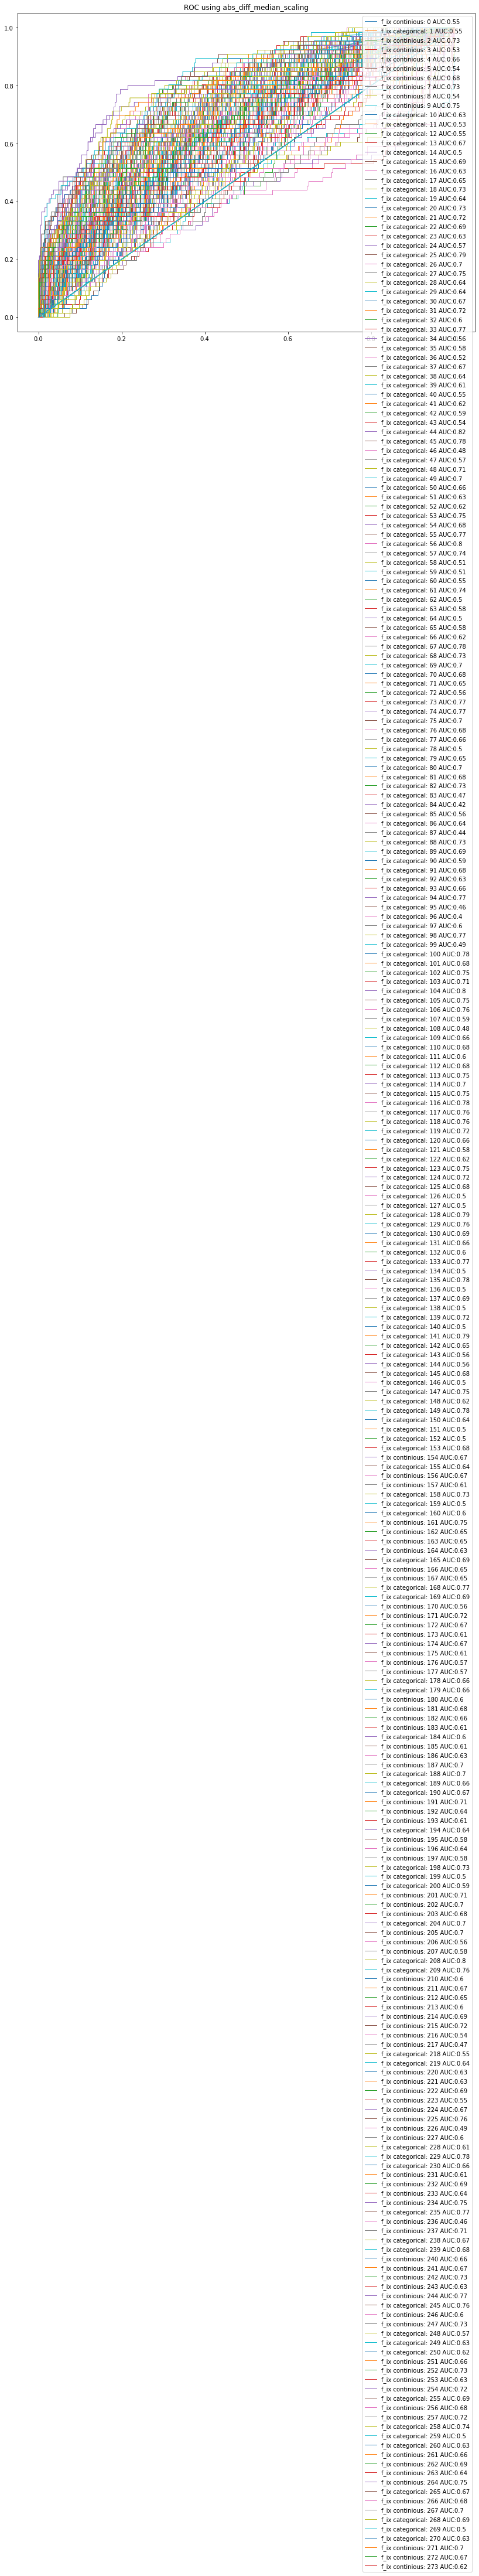

0.8219108180248077


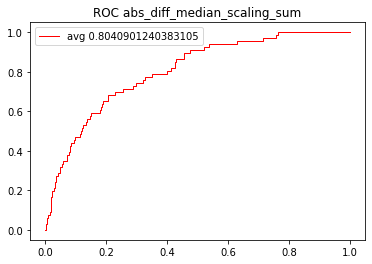

In [16]:
metric_name = 'abs_diff_median_scaling'
plt.figure(figsize=[14, 10])
auc=[]
columns_list_names=['{}_{}'.format(metric_name, feature_index) for feature_index in num_feature_index]

for feature_index in num_feature_index:
    fpr, tpr, thresholds = metrics.roc_curve(label.flatten(),
                                             results_all_features_pd['{}_{}'.format(metric_name, feature_index )],
                                             pos_label=1)
    if len(set(features[:, feature_index])) > min_number_of_values:
        message = "f_ix continious: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    else:
        message = "f_ix categorical: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    plt.plot(fpr, tpr, lw=1, label=message,
             color='C{}'.format(feature_index%10))
    plt.title("ROC using {}".format(metric_name))
    auc.append(metrics.auc(fpr, tpr))
plt.legend()
plt.show()
print(max(auc))

# simple sum
metric_sum =(results_all_features_pd[columns_list_names]).sum(axis=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(label.flatten(), metric_sum, pos_label=1)
plt.plot(fpr1, tpr1, color='red', lw=1, label='avg {}'.format(metrics.auc(fpr1, tpr1)))
plt.title("ROC {}_sum".format(metric_name))
plt.legend()
plt.show()